# Rebuilding the PyTorch training loop in simple Python
___

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Rebuilding-the-PyTorch-training-loop-in-simple-Python" data-toc-modified-id="Rebuilding-the-PyTorch-training-loop-in-simple-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rebuilding the PyTorch training loop in simple Python</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Pre-process-Data" data-toc-modified-id="Pre-process-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Pre-process Data</a></span></li></ul></li><li><span><a href="#Bare-Training-Loop" data-toc-modified-id="Bare-Training-Loop-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bare Training Loop</a></span><ul class="toc-item"><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Build Model</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></li><li><span><a href="#PyTorch-Data-Abstractions" data-toc-modified-id="PyTorch-Data-Abstractions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyTorch Data Abstractions</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Dataloader" data-toc-modified-id="Dataloader-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dataloader</a></span></li><li><span><a href="#Random-Sampler" data-toc-modified-id="Random-Sampler-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Sampler</a></span></li></ul></li><li><span><a href="#PyTorch-Training-Abstractions" data-toc-modified-id="PyTorch-Training-Abstractions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PyTorch Training Abstractions</a></span><ul class="toc-item"><li><span><a href="#nn.Parameters" data-toc-modified-id="nn.Parameters-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>nn.Parameters</a></span></li><li><span><a href="#nn.Sequential" data-toc-modified-id="nn.Sequential-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>nn.Sequential</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Optimizer</a></span></li></ul></li><li><span><a href="#Validation" data-toc-modified-id="Validation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation</a></span></li></ul></div>

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
dataset = MNIST(root="../data/")

In [3]:
x, y = dataset.data.float(), dataset.targets
x_train, x_test = x[:50000], x[50000:]
y_train, y_test = y[:50000], y[50000:]

x_train.shape, x_test.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

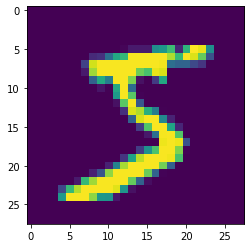

In [4]:
plt.imshow(x_train[0])

**Flatten**

In [5]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

## Pre-process Data

In [7]:
def normalize(x, mean, std): 
    return (x-mean)/std

In [8]:
train_mean = x_train.mean()
train_std = x_train.std()

In [9]:
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

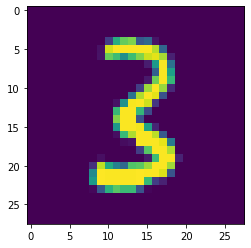

In [10]:
plt.imshow(x_test[0].view(28,28))

# Bare Training Loop
---

## Build Model

In [11]:
class FC(nn.Module):
    
    def __init__(self, x_dim, y_dim, h_dim):
        super().__init__()
        self.layers = [nn.Linear(x_dim, h_dim),
                       nn.ReLU(),
                       nn.Linear(h_dim, y_dim)]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

**Model Config:**

In [12]:
n, m = x_train.shape
c = (y_train.max() - y_train.min()+1).item()
n, m, c

(50000, 784, 10)

In [13]:
model = FC(m, c, 300)

## Train Model

**Training Config:**

In [14]:
epochs = 10
lr = 1e-3
bs = 128
loss_fn = F.cross_entropy

In [15]:
for epoch in range(epochs):
    num_batches = (n-1)//bs
    for i in range(num_batches):
        # data minibatch
        start_idx, end_idx = bs*i, bs*(i+1)
        xb = x_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

## Evaluate Model

In [16]:
def accuracy(input, target):
    input_pred = torch.argmax(input, dim=-1)
    return (input_pred==target).float().mean()

In [17]:
loss_fn(model(x_train), y_train)

tensor(0.4428, grad_fn=<NllLossBackward>)

In [18]:
accuracy(model(x_train), y_train)

tensor(0.8839)

# PyTorch Data Abstractions
---

## Dataset
**A simple wrapper for x's and y's**

In [19]:
class Dataset():
    
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

**Training Loop using Dataset abstraction**

In [20]:
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_train, y_test)

In [21]:
for epoch in range(epochs):
    num_batches = (n-1)//bs
    for i in range(num_batches):
        # data minibatch
        xb,yb = train_ds[bs*i:bs*(i+1)]
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

In [22]:
accuracy(model(x_train), y_train)

tensor(0.9029)

## Dataloader
**Loading minibatches from a Dataset**

In [23]:
class DataLoader():
    
    def __init__(self, dataset, batch_size):
        self.ds, self.bs = dataset, batch_size
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

**Example:**

In [24]:
x = torch.Tensor(range(10))
y = x*x
dummy_ds = Dataset(x,y)
dummy_dl = DataLoader(dummy_ds, 2)

In [25]:
[(xb,yb) for xb,yb in dummy_dl]

[(tensor([0., 1.]), tensor([0., 1.])),
 (tensor([2., 3.]), tensor([4., 9.])),
 (tensor([4., 5.]), tensor([16., 25.])),
 (tensor([6., 7.]), tensor([36., 49.])),
 (tensor([8., 9.]), tensor([64., 81.]))]

**Training Loop using DataLoader abstraction**

In [26]:
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_train, y_test)

train_dl = DataLoader(train_ds, bs)
test_dl = DataLoader(test_ds, bs)

In [27]:
for epoch in range(epochs):
    # data minibatch
    for xb,yb in train_dl:
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

In [28]:
accuracy(model(x_train), y_train)

tensor(0.9130)

## Random Sampler
**Shuffles data during batch training**

In [29]:
class Sampler():
    
    def __init__(self, data_size, batch_size, shuffle):
        self.n, self.bs, self.shuffle = data_size, batch_size, shuffle
        
    def __iter__(self):
        sample_idx = torch.randperm(self.n) if self.shuffle else list(range(self.n))
        for i in range(0, self.n, self.bs):
            yield sample_idx[i : i+self.bs]

**Example:**

In [30]:
x = torch.Tensor(range(10))
y = x*x
dummy_samp = Sampler(10, 2, False)
print([samples for samples in dummy_samp])

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]


In [31]:
x = torch.Tensor(range(10))
y = x*x
dummy_samp = Sampler(10, 2, True)
print([samples for samples in dummy_samp])

[tensor([4, 1]), tensor([8, 3]), tensor([6, 5]), tensor([2, 0]), tensor([7, 9])]


**DataLoader with shuffling feature**

In [32]:
class DataLoader():
    
    def __init__(self, dataset, batch_size, sampler, collate_fn):
        self.ds, self.bs = dataset, batch_size        
        self.sampler, self.collate_fn = sampler, collate_fn
    
    def __iter__(self):
        for batch_idxs in self.sampler:
            yield self.collate_fn([self.ds[idx] for idx in batch_idxs])

In [33]:
def collate(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs), torch.stack(ys)

**Example:**

In [34]:
x = torch.Tensor(range(10))
y = x*x

dummy_ds =  Dataset(x, y)
dummy_samp = Sampler(10, 2, False)
dummy_dl = DataLoader(dummy_ds, bs, dummy_samp, collate)

[batch for batch in dummy_dl]

[(tensor([0., 1.]), tensor([0., 1.])),
 (tensor([2., 3.]), tensor([4., 9.])),
 (tensor([4., 5.]), tensor([16., 25.])),
 (tensor([6., 7.]), tensor([36., 49.])),
 (tensor([8., 9.]), tensor([64., 81.]))]

In [34]:
x = torch.Tensor(range(10))
y = x*x

dummy_ds =  Dataset(x, y)
dummy_samp = Sampler(10, 2, True)
dummy_dl = DataLoader(dummy_ds, bs, dummy_samp, collate)

[batch for batch in dummy_dl]

[(tensor([9., 8.]), tensor([81., 64.])),
 (tensor([2., 5.]), tensor([ 4., 25.])),
 (tensor([4., 6.]), tensor([16., 36.])),
 (tensor([7., 0.]), tensor([49.,  0.])),
 (tensor([1., 3.]), tensor([1., 9.]))]

**Training Loop with shuffled DataLoader**

In [35]:
def get_dataloaders(x_train, y_train, x_test, y_test, bs, collate):
    train_ds = Dataset(x_train, y_train)
    test_ds = Dataset(x_test, y_test)

    train_samp = Sampler(len(train_ds), bs, shuffle=True)
    test_samp = Sampler(len(test_ds), bs, shuffle=False)

    train_dl = DataLoader(train_ds, bs, train_samp, collate)
    test_dl = DataLoader(test_ds, bs, test_samp, collate)
    
    return train_dl, test_dl

In [36]:
train_dl, test_dl = get_dataloaders(x_train, y_train,
                                    x_test, y_test,
                                    bs, collate)

In [37]:
for epoch in range(epochs):
    # data minibatch
    for xb,yb in train_dl:
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()               

In [38]:
accuracy(model(x_train), y_train)

tensor(0.9200)

# PyTorch Training Abstractions
---

## nn.Parameters
**All trainable parameters of the model are abstracted together**

**How PyTorch does it?**

In [46]:
class Model(nn.Module):
    
    def __init__(self, x_dim, y_dim, h_dim):
        super().__init__()
        self.l1 = nn.Linear(x_dim, h_dim)
        self.l2 = nn.Linear(h_dim, y_dim)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        return self.l2(x)

In [47]:
model = Model(784,10,300)
model

Model(
  (l1): Linear(in_features=784, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=10, bias=True)
)

In [48]:
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, bs, collate)

In [77]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
                p.grad.zero_()

In [78]:
accuracy(model(x_train), y_train)

tensor(0.9030)

**How to rebuild this functionality?**

In [71]:
class OurModule():
    
    def __init__(self, x_dim, y_dim, h_dim):
        self._modules = {}
        self.l1 = nn.Linear(x_dim, h_dim)
        self.l2 = nn.Linear(h_dim, y_dim)
    
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self):
        return f"{self._modules}"
    
    def parameters(self):
        for m in self._modules.values():
            for p in m.parameters():
                yield p
    
    def __call__(self, x):
        x = F.relu(self.l1(x))
        return self.l2(x)

In [72]:
model = OurModule(784,10,300)
model

{'l1': Linear(in_features=784, out_features=300, bias=True), 'l2': Linear(in_features=300, out_features=10, bias=True)}

In [73]:
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, bs, collate)

In [75]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
                p.grad.zero_()

In [76]:
accuracy(model(x_train), y_train)

tensor(0.8843)

## nn.Sequential
**Quick model construction by defining a list of layers**

**How PyTorch does it?**

In [81]:
model = nn.Sequential(nn.Linear(784,300), nn.ReLU(), nn.Linear(300,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

**How to rebuild this functionality?**

In [86]:
class Sequential(nn.Module):
    
    def __init__(self, *layers):
        super().__init__()
        self.layers = self.module_list(layers)
    
    def module_list(self, layers):
        for i, l in enumerate(layers):
            self.add_module(name = f'{i}',
                            module = l)
    
    def forward(self):
        for l in self.layers:
            x = l(x)
        return x        

In [87]:
model = Sequential(nn.Linear(784,300), nn.ReLU(), nn.Linear(300,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

## Optimizer
**Abstracting away the optimization function used to train a model**

**How PyTorch does it?**

In [88]:
model = nn.Sequential(nn.Linear(784,300), nn.ReLU(), nn.Linear(300,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

In [89]:
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, bs, collate)

In [90]:
opt = torch.optim.SGD(model.parameters(), lr=0.5)

In [91]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [92]:
accuracy(model(x_train), y_train)

tensor(0.9995)

**How to rebuild this functionality?**

In [105]:
class Optimizer():
    
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= lr * p.grad
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [106]:
model = nn.Sequential(nn.Linear(784,300), nn.ReLU(), nn.Linear(300,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

In [107]:
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, bs, collate)

In [108]:
opt = Optimizer(model.parameters(), lr=0.)

In [109]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [110]:
accuracy(model(x_train), y_train)

tensor(0.8854)

# Validation
---

**Learning model**

In [122]:
model = nn.Sequential(nn.Linear(784,300), nn.ReLU(), nn.Linear(300,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

**Data**

In [123]:
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, bs, collate)

**Optimizer**

In [124]:
opt = torch.optim.SGD(model.parameters(), lr=0.5)

**Training & Validation Loop**

In [127]:
for epoch in range(epochs):
    # Train model
    model.train()
    for xb,yb in train_dl:
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    # Validate model
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for xb, yb in test_dl:
            yb_pred = model(xb)
            loss += loss_fn(yb_pred, yb)
            acc += accuracy(yb_pred, yb)
            n += len(xb)
        loss = loss/n * 100
        acc = acc/n * 100
    print(f"EPOCH#:{epoch} \t Loss: {loss:.4f} Accuracy: {acc:.4f}")

EPOCH#:0 	 Loss: 0.0623 Accuracy: 0.7748
EPOCH#:1 	 Loss: 0.0630 Accuracy: 0.7746
EPOCH#:2 	 Loss: 0.0629 Accuracy: 0.7751
EPOCH#:3 	 Loss: 0.0635 Accuracy: 0.7746
EPOCH#:4 	 Loss: 0.0633 Accuracy: 0.7748
EPOCH#:5 	 Loss: 0.0636 Accuracy: 0.7750
EPOCH#:6 	 Loss: 0.0639 Accuracy: 0.7751
EPOCH#:7 	 Loss: 0.0644 Accuracy: 0.7753
EPOCH#:8 	 Loss: 0.0642 Accuracy: 0.7751
EPOCH#:9 	 Loss: 0.0648 Accuracy: 0.7750
